# Compare simulation and mean field for Potjans' model


In [101]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
plt.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)

colors = style.colors

## Mean field model

In [102]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=False, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
        
def CV_ISI_mf(v0, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import dblquad
    from scipy.special import erf
    mu     = model.mu(v0)
    sd     = model.sd(v0)
    lows   = (model.V_r - mu) / sd
    ups    = (model.theta - mu) / sd
    bounds = np.array([lows, ups]).T

    # Double integral
    def func(u, x):
        if u < -4.0:
            return np.exp(x**2) * \
                np.exp(-u**2) / np.sqrt(np.pi) * (u**-2
                                                    - u**-4
                                                    + 7.0 * u**-6 / 4.0
                                                    - 9.0 * u**-8 / 2.0)
        else:
            return np.exp(x**2) * np.exp(u**2) * (1. + erf(u))**2

    gfun = lambda x: -np.inf
    hfun = lambda x: x
    dbl_integral  = np.array([dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)[0]
                                   for low, up in bounds])

    cv_theo = np.sqrt(2 * np.pi * v0**2 * dbl_integral * model.tau_m**2) # Define as sd / mean, NOT var / mean**2
    return cv_theo

In [103]:
def plot_compare_sim_mf(data_sim, data_mf, ax):
    y_mf = np.arange(n_populations) + 0.1
    yticks = np.arange(n_populations) + 0.5
    if reverse_order:
        y_mf = y_mf[::-1]
        yticks = yticks[::-1]
    bar_height = 0.8 

    for i, population in enumerate(populations):
        ax.plot(data_sim[:, i], [yticks[i]]*rates_mean_all.shape[0], '+', color=colors[i], mew=2, ms=20)
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                color=colors[i], linewidth=0, fill=True, alpha=0.4) 
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                edgecolor=colors[i], linewidth=2, fill=False, alpha=1.0) 
    ax.barh([0], [0], color="lightgray", edgecolor="darkgray", linewidth=2, fill=True, alpha=1.0, label="mean field") 
    ax.plot([-1], [0], "+", color="gray", alpha=1.0, label="simulated", mew=2, ms=5) 

    yticklabels = hf.rlbl(populations)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

## With connection_rule = "fixed_total_number":

Integration time: 0.12
CV calc time: 0.66


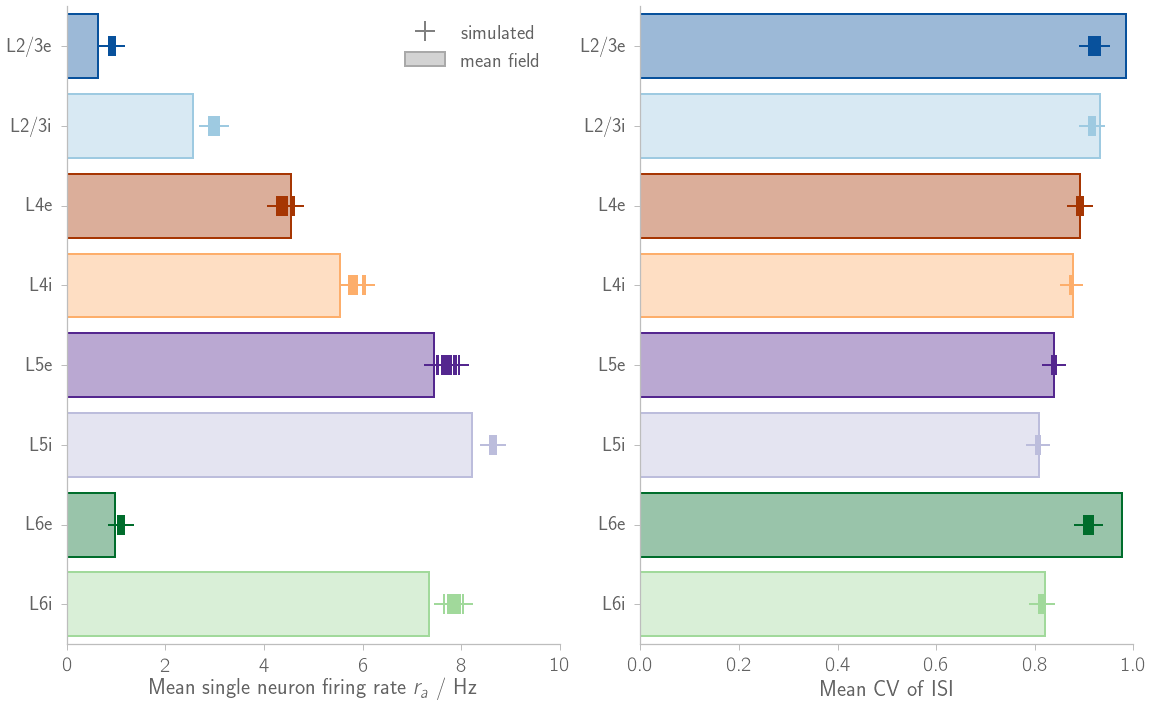

In [104]:
######################################################
# Mean field results
######################################################

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
model_micro     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model_micro, v_guess_0,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model_micro)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))

######################################################
# Simulation results
######################################################
# DATA
sim_spec = "spon_act_statistic"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all = np.zeros((n_sims, n_populations))
    cv_isi_mean_all     = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        
######################################################
# Plotting
######################################################

fig = plt.figure()

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_xlim(0, 10)
ax1.legend(loc="best")
    
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
data = cv_isi_mean_all
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Mean CV of ISI")
ax2.set_xlim(0, 1)

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_fixed_total_number"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Print numerical results: Rates and CV of ISI (for latex)

In [105]:
# Firing rates
r_mf = rate_mf
r_sim = np.mean(rates_mean_all, axis=0)

# Absolute deviation for rates
drs = (r_mf - r_sim)
drstr = ""
for dr in drs:
    drstr += "& {0:5.2f} ".format(dr)
drstr += r"\tn[0.2cm]"
# Relative deviation for rates
rdrs = drs / r_sim
rdrstr = ""
for rdr in rdrs:
    rdrstr += "& {0:5.2f} ".format(rdr)
rdrstr += r"\tn[0.2cm]"
    
# String for Table    
tabstr  = r"$\Delta r_a$ / Hz"  + "\n    "
tabstr += drstr  + "\n"
tabstr += r"$\Delta r_a / r_{\text{sim}, a}$"  + "\n    "
tabstr += rdrstr  + "\n"
print(tabstr)


mean_str = "({0:4.2f} \\pm {1:4.2f}) Hz".format(np.mean(abs(drs)), np.std(abs(drs)))
print(mean_str)
print("\n")

# CV of ISI
r_mf = cv_isi_mf 
r_sim = np.mean(cv_isi_mean_all, axis=0)

# Absolute deviation for rates
drs = (r_mf - r_sim)
drstr = ""
for dr in drs:
    drstr += "& {0:5.2f} ".format(dr)
drstr += r"\tn[0.2cm]"
# Relative deviation for rates
rdrs = drs / r_sim
rdrstr = ""
for rdr in rdrs:
    rdrstr += "& {0:5.2f} ".format(rdr)
rdrstr += r"\tn[0.2cm]"
    
# String for Table    
tabstr  = r"$\Delta \text{CV}_a$"  + "\n    "
tabstr += drstr  + "\n"
tabstr += r"$\Delta \text{CV}_a / \text{CV}_{\text{sim}, a}$"  + "\n    "
tabstr += rdrstr  + "\n"
print(tabstr)

mean_str = "({0:4.2f} \\pm {1:4.2f})".format(np.mean(abs(drs)), np.std(abs(drs)))
proz_str = "({0:d} \\pm {1:d})".format(int(np.mean(abs(drs)) / np.mean(r_sim) * 100), 
                                       int(np.std(abs(drs)) / np.mean(r_sim) * 100))
print(mean_str)
print(proz_str)

$\Delta r_a$ / Hz
    & -0.28 & -0.44 &  0.15 & -0.30 & -0.26 & -0.43 & -0.12 & -0.51 \tn[0.2cm]
$\Delta r_a / r_{\text{sim}, a}$
    & -0.31 & -0.15 &  0.03 & -0.05 & -0.03 & -0.05 & -0.11 & -0.06 \tn[0.2cm]

(0.31 \pm 0.13) Hz


$\Delta \text{CV}_a$
    &  0.06 &  0.02 & -0.00 &  0.00 &  0.00 &  0.00 &  0.07 &  0.01 \tn[0.2cm]
$\Delta \text{CV}_a / \text{CV}_{\text{sim}, a}$
    &  0.07 &  0.02 & -0.00 &  0.00 &  0.00 &  0.00 &  0.07 &  0.01 \tn[0.2cm]

(0.02 \pm 0.03)
(2 \pm 3)


## With connection_rule = "fixed_indegree":

Integration time: 0.12
CV calc time: 0.67


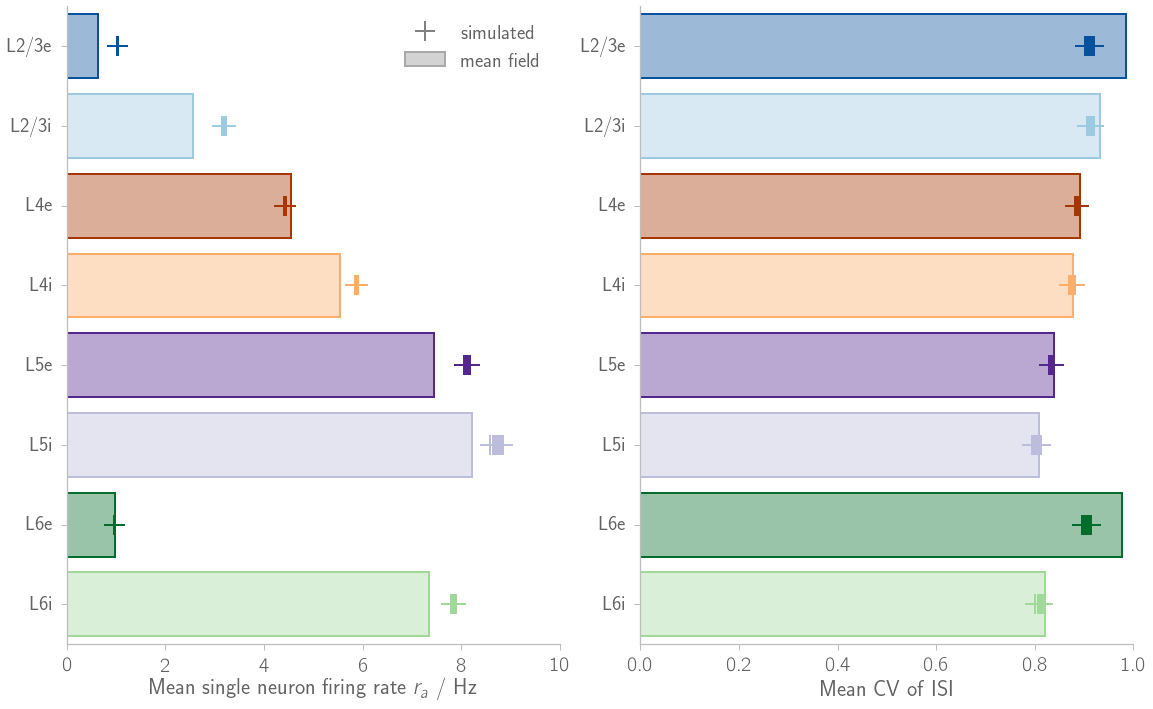

In [106]:
######################################################
# Mean field results
######################################################

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
model_micro     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model_micro, v_guess_0,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model_micro)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
######################################################
# DATA
sim_spec = "a1.0_t20.2_fixindeg_01"
#sim_spec = "simulation_at_mf"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all = np.zeros((n_sims, n_populations))
    cv_isi_mean_all     = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        
######################################################
# Plotting
######################################################

fig = plt.figure()

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_xlim(0, 10)
ax1.legend(loc="best")
    
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
data = cv_isi_mean_all
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Mean CV of ISI")
ax2.set_xlim(0, 1)

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_fixed_indegree"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

# Check $\mu$ and $\sigma$
### For consistency, and for the numerical stability of the algorithm applied...

In [10]:
mu_brunel = model_micro.mu(rate_mf[::-1])
sd_brunel = model_micro.sd(rate_mf[::-1])
mu_brunel, sd_brunel

(array([ 35.95056827,  41.19447994,   3.9172597 ,  20.65606839,
         50.05094192,  34.03839799,  40.74860721,  37.68801014]),
 array([ 5.8335019 ,  4.80950918,  5.48111228,  6.18623123,  4.504506  ,
         3.73627247,  3.47004715,  2.66128992]))

### Check numerics

In [241]:
# %load "../analysis/trans_mean_field.py"
def check_solve(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root
    # Instantiation
    if jacobian:
        jac = model.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    v0  = sol["x"]
    return v0, sol
        

connection_rule = "fixed_indegree"
model_micro       = model_class.model(connection_rule=connection_rule) 

#v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])

n_sims = len(rates_mean_all)
tints = np.zeros(n_sims)
nfevs = np.zeros(n_sims)
for j in range(n_sims):
    v_guess_0       = rates_mean_all[j]

    jacobian=False
    root_method='hybr'
    options= {"xtol": 1e-13, "maxfev": 10**4}

    t_int0      = time.time()
    rate_mf, sol = check_solve(model_micro, v_guess_0,
                    jacobian=jacobian, root_method=root_method, options=options)
    t_int1      = time.time() - t_int0
    print("%i\tt_int: %.2f\t nfev: %i\t success: "%(j, t_int1, sol["nfev"]) + str(sol["success"]))
    
    tints[j] = t_int1
    nfevs[j] = sol["nfev"]
    
print(np.mean(tints), np.std(tints))
print(np.mean(nfevs), np.std(nfevs))

0	t_int: 0.08	 nfev: 44	 success: True
1	t_int: 0.06	 nfev: 36	 success: True
2	t_int: 0.06	 nfev: 34	 success: True
3	t_int: 0.08	 nfev: 43	 success: True
4	t_int: 0.06	 nfev: 35	 success: True
5	t_int: 0.12	 nfev: 81	 success: True
6	t_int: 0.07	 nfev: 42	 success: True
7	t_int: 0.06	 nfev: 35	 success: True
8	t_int: 0.05	 nfev: 30	 success: True
9	t_int: 0.11	 nfev: 68	 success: True
10	t_int: 0.06	 nfev: 36	 success: True
11	t_int: 0.08	 nfev: 45	 success: True
12	t_int: 0.06	 nfev: 35	 success: True
13	t_int: 0.06	 nfev: 39	 success: True
14	t_int: 0.08	 nfev: 48	 success: True
15	t_int: 0.06	 nfev: 39	 success: True
16	t_int: 0.07	 nfev: 41	 success: True
17	t_int: 0.06	 nfev: 34	 success: True
18	t_int: 0.06	 nfev: 35	 success: True
19	t_int: 0.05	 nfev: 32	 success: True
0.0687725782394 0.0179775705609
41.6 12.0474063599


In [236]:
# %load "../analysis/trans_mean_field.py"
def check_solve(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root
    # Instantiation
    if jacobian:
        jac = model.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    v0  = sol["x"]
    return v0, sol
        

connection_rule = "fixed_indegree"
model_micro       = model_class.model(connection_rule=connection_rule) 

#v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])

n_sims = len(rates_mean_all)
tints = np.zeros(n_sims)
nfevs = np.zeros(n_sims)
for j in range(n_sims):
    v_guess_0       = rates_mean_all[j]

    jacobian=False
    root_method='hybr'
    options= {"xtol": 1e-13, "maxfev": 10**4}

    t_int0      = time.time()
    rate_mf, sol = check_solve(model_micro, v_guess_0,
                    jacobian=jacobian, root_method=root_method, options=options)
    t_int1      = time.time() - t_int0
    print("%i\tt_int: %.2f\t nfev: %i\t success: "%(j, t_int1, sol["nfev"]) + str(sol["success"]))
    
    tints[j] = t_int1
    nfevs[j] = sol["nfev"]
    
print(np.mean(tints), np.mean(nfevs))

0	t_int: 0.06	 nfev: 34	 success: True
1	t_int: 0.05	 nfev: 34	 success: True
2	t_int: 0.05	 nfev: 33	 success: True
3	t_int: 0.05	 nfev: 32	 success: True
4	t_int: 0.06	 nfev: 40	 success: True
5	t_int: 0.06	 nfev: 34	 success: True
6	t_int: 0.06	 nfev: 32	 success: True
7	t_int: 0.05	 nfev: 31	 success: True
8	t_int: 0.05	 nfev: 31	 success: True
9	t_int: 0.06	 nfev: 37	 success: True
10	t_int: 0.07	 nfev: 43	 success: True
11	t_int: 0.06	 nfev: 35	 success: True
12	t_int: 0.06	 nfev: 35	 success: True
13	t_int: 0.06	 nfev: 35	 success: True
14	t_int: 0.05	 nfev: 32	 success: True
15	t_int: 0.05	 nfev: 33	 success: True
16	t_int: 0.06	 nfev: 33	 success: True
17	t_int: 0.06	 nfev: 36	 success: True
18	t_int: 0.05	 nfev: 33	 success: True
19	t_int: 0.07	 nfev: 42	 success: True
0.057181084156 34.75


## Test dependency on $\Delta J$

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

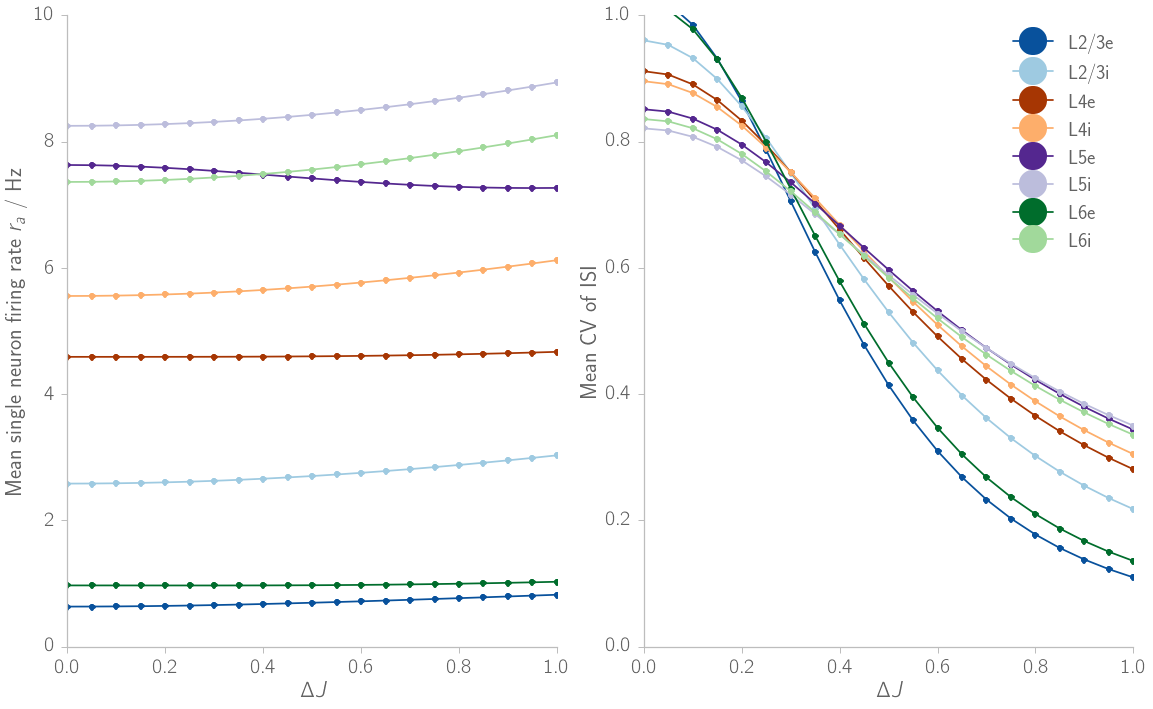

In [85]:
# Data
sim_spec = "a1.0_t20.4_00"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)
(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

n = 21
weight_rel_sds   = np.linspace(0, 1.0, n)
rates       = np.zeros((n, n_populations))
cv_isis     = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"


v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for j, weight_rel_sd in enumerate(weight_rel_sds):
    print(j, end=" ")

    model_micro     = model_class.model(neuron_model=neuron_model,
                                        connection_rule=connection_rule, 
                                        weight_rel_sd=weight_rel_sd) 
    t_int0      = time.time()
    rates[j]     = solve_model(model_micro, v_guess_0,
                              root_method=root_method, options=options)
    t_int1      = time.time() - t_int0
    #print("Integration time: %.2f"%(t_int1))

    t_int0      = time.time()
    cv_isis[j]   = CV_ISI_mf(rate_mf, model=model_micro)
    t_int1      = time.time() - t_int0
    #print("CV calc time: %.2f"%(t_int1))


fig = plt.figure()

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for i, population in enumerate(populations):
    ax1.plot(weight_rel_sds, rates[:, i], '-o', color=colors[i],
        label=hf.rlbl(population))
    ax2.plot(weight_rel_sds, cv_isis[:, i], '-o', color=colors[i],
        label=hf.rlbl(population))
    

ax1.set_ylabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_ylim(0, 10)

ax2.set_ylabel("Mean CV of ISI")
ax2.set_ylim(0, 1)
ax2.legend(loc="best")

for ax in fig.axes:
    ax.set_xlabel("$\Delta J$")
    style.fixticks(ax)